In [1]:
import glob
import pandas as pd
from scipy import stats
import numpy as np
import itertools

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Glob pattern to match infodata and lanedata files
lanedata_pattern = '../output/lanedata*.csv'
infodata_pattern = '../output/infodata*.csv'

# Get lists of matching file paths
lanedata_files = glob.glob(lanedata_pattern)
infodata_files = glob.glob(infodata_pattern)

# Read each pair of files into a DataFrame and concatenate them
dfs = [pd.read_csv(file) for file in lanedata_files]
dfs_info = [pd.read_csv(file) for file in infodata_files]

# Concatenate all DataFrames and filter for 'emergency_emergency' vehicle type
df = pd.concat(dfs, ignore_index=True)
df_info = pd.concat(dfs_info, ignore_index=True)
df_info = df_info[df_info['vType'] == 'emergency_emergency']

# Display the first two rows
print(df.head(2))

       id  sampledSeconds  traveltime  overlapTraveltime  density  \
0  A0A1_0         7250.44       34.67              35.43    11.38   
1  A0A1_1         1816.00       37.87              38.58     2.85   

   laneDensity  occupancy  waitingTime  timeLoss  speed  ...  teleported  \
0        11.38       5.57       1579.0   3014.98   7.95  ...           0   
1         2.85       1.39        557.0    877.16   7.31  ...           0   

   vaporized     end        seed  ALGORITHM  \
0          0  2302.0  1835732737    default   
1          0  2302.0  1835732737    default   

   DELAY_TO_DISPATCH_EMERGENCY_VEHICLE  CAR_FOLLOW_MODEL  \
0                                 30.0            Krauss   
1                                 30.0            Krauss   

   TIME_TO_BLOCK_CREATE_ACCIDENTS  SAVEDS  UNSAVEDS  
0                            50.0       6         2  
1                            50.0       6         2  

[2 rows x 27 columns]


In [4]:
df_info.columns

Index(['id', 'depart', 'departLane', 'departPos', 'departPosLat',
       'departSpeed', 'departDelay', 'arrival', 'arrivalLane', 'arrivalPos',
       'arrivalPosLat', 'arrivalSpeed', 'duration', 'routeLength',
       'waitingTime', 'waitingCount', 'stopTime', 'timeLoss', 'rerouteNo',
       'devices', 'vType', 'speedFactor', 'vaporized', 'CO_abs', 'CO2_abs',
       'HC_abs', 'PMx_abs', 'NOx_abs', 'fuel_abs', 'seed', 'ALGORITHM',
       'DELAY_TO_DISPATCH_EMERGENCY_VEHICLE', 'CAR_FOLLOW_MODEL',
       'TIME_TO_BLOCK_CREATE_ACCIDENTS', 'SAVEDS', 'UNSAVEDS'],
      dtype='object')

In [3]:
new_df_info = df_info[['seed', 'duration', 'ALGORITHM']]

In [4]:
new_df = df[['seed', 'occupancy', 'ALGORITHM']]

In [7]:
new_df

,seed,occupancy,ALGORITHM
0,1835732737,5.57,default
1,1835732737,1.39,default
2,1835732737,0.73,default
3,1835732737,1.84,default
4,1835732737,1.02,default
...,...,...,...
38395,1835732737,15.53,default
38396,1835732737,34.60,default
38397,1835732737,4.03,default
38398,1835732737,1.21,default


In [5]:
# df_occupancy = new_df.groupby(by=['seed', 'ALGORITHM'])['occupancy']
df_traveltime = new_df_info.groupby(by=['seed', 'ALGORITHM'])['duration'].mean()

In [6]:
# Merge the DataFrames on 'seed' and 'ALGORITHM' columns
merged_df = pd.merge(new_df, df_traveltime, on=['seed', 'ALGORITHM'], how='inner')

# Rename the columns for clarity (optional)
merged_df = merged_df.rename(columns={'duration': 'mean_travel_time'})

# Now `merged_df` contains both average occupancy and average travel time for each seed and algorithm
print(merged_df)

             seed  occupancy ALGORITHM  mean_travel_time
0      1835732737       5.57   default        830.527273
1      1835732737       1.39   default        830.527273
2      1835732737       0.73   default        830.527273
3      1835732737       1.84   default        830.527273
4      1835732737       1.02   default        830.527273
...           ...        ...       ...               ...
38395  1835732737      15.53   default        830.527273
38396  1835732737      34.60   default        830.527273
38397  1835732737       4.03   default        830.527273
38398  1835732737       1.21   default        830.527273
38399  1835732737       0.54   default        830.527273

[38400 rows x 4 columns]


<Axes: xlabel='occupancy', ylabel='mean_travel_time'>

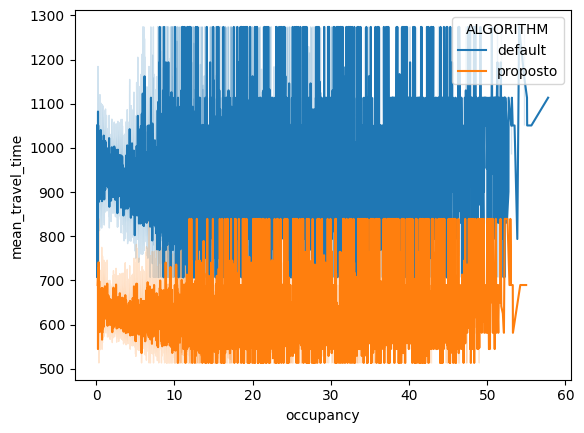

In [9]:
sns.lineplot(data=merged_df, x='occupancy', y='mean_travel_time', hue='ALGORITHM')

In [18]:
# Filter data for each algorithm
default_df = merged_df[merged_df['ALGORITHM'] == 'default']
proposto_df = merged_df[merged_df['ALGORITHM'] == 'proposto']

# Now you can use these Series for plotting
sns.lineplot(x=default_df['mean_occupancy'], y=default_df['mean_travel_time'], label='Without Green Wave', err_style="bars", errorbar=("se", 2),)
sns.lineplot(x=proposto_df['mean_occupancy'], y=proposto_df['mean_travel_time'], label='With Green Wave', err_style="bars", errorbar=("se", 2),)

plt.xlabel("Occupancy")
plt.ylabel("Total travel time (in seconds)")
plt.title("Traveltime vs. Occupancy for Different Algorithms")
plt.legend(title='Algorithm')
plt.show()

KeyError: 'ALGORITHM'

In [6]:
df.describe()

,sampledSeconds,traveltime,overlapTraveltime,density,laneDensity,occupancy,waitingTime,timeLoss,speed,speedRelative,...,laneChangedFrom,laneChangedTo,teleported,vaporized,end,seed,DELAY_TO_DISPATCH_EMERGENCY_VEHICLE,TIME_TO_BLOCK_CREATE_ACCIDENTS,SAVEDS,UNSAVEDS
count,3.840000e+04,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000,3.840000e+04,3.840000e+04,38400.000000,38400.000000,...,38400.000000,38400.000000,38400.000000,38400.000000,38400.000000,3.840000e+04,38400.000000,38400.000000,38400.000000,38400.000000
mean,1.806437e+04,189.533727,192.040954,19.194118,19.194118,9.516878,1.398791e+04,1.578476e+04,5.245391,0.377647,...,91.008490,91.284167,1.545495,0.032135,3647.043750,1.101536e+09,75.000000,75.000000,4.793750,3.081250
std,4.387549e+04,429.342368,433.423121,25.297131,25.297131,12.634829,4.222213e+04,4.351285e+04,3.566158,0.256751,...,58.379763,60.562927,5.184737,0.231075,3915.678267,5.500707e+08,45.000586,25.000326,2.332135,1.746347
min,1.509900e+02,19.910000,20.450000,0.020000,0.020000,0.010000,0.000000e+00,1.170000e+01,0.030000,0.000000,...,0.000000,4.000000,0.000000,0.000000,1539.000000,2.004967e+08,30.000000,50.000000,0.000000,0.000000
25%,2.730487e+03,34.747500,35.570000,3.670000,3.670000,1.800000,6.340000e+02,1.108175e+03,1.680000,0.120000,...,48.000000,55.000000,0.000000,0.000000,2096.000000,6.338163e+08,30.000000,50.000000,3.000000,2.000000
50%,5.329475e+03,48.280000,49.825000,7.580000,7.580000,3.720000,1.775000e+03,2.938065e+03,5.590000,0.400000,...,86.000000,74.000000,0.000000,0.000000,2471.500000,1.214100e+09,75.000000,75.000000,5.000000,3.000000
75%,1.650501e+04,162.537500,165.842500,22.622500,22.622500,11.172500,1.062825e+04,1.337570e+04,7.820000,0.560000,...,124.000000,108.000000,1.000000,0.000000,3064.000000,1.410143e+09,120.000000,100.000000,6.000000,4.000000
max,1.078014e+06,9461.050000,9581.050000,133.330000,133.330000,91.470000,1.047304e+06,1.072175e+06,13.780000,0.990000,...,1277.000000,1337.000000,80.000000,3.000000,25134.000000,1.954325e+09,120.000000,100.000000,11.000000,8.000000


In [17]:
df['id'], df['entered']-df['left']

(0        A0A1_0
 1        A0A1_1
 2        A0A1_2
 3        A0B0_0
 4        A0B0_1
           ...  
 38395    E4D4_1
 38396    E4D4_2
 38397    E4E3_0
 38398    E4E3_1
 38399    E4E3_2
 Name: id, Length: 38400, dtype: object,
 0        -5
 1        -1
 2        -4
 3        38
 4         1
          ..
 38395    23
 38396   -54
 38397   -32
 38398    21
 38399    -7
 Length: 38400, dtype: int64)

In [3]:
df['car_per_hour'] = df['entered'] * 3600 / df['end']

In [4]:
lista_index = ['ALGORITHM', 'TIME_TO_BLOCK_CREATE_ACCIDENTS', 'DELAY_TO_DISPATCH_EMERGENCY_VEHICLE','CAR_FOLLOW_MODEL']
to_exclude = [
   'sampledSeconds', 
       'laneDensity', 'occupancy', 'waitingTime', 'departed', 'arrived', 
       'laneChangedFrom', 'laneChangedTo', 'teleported', 'vaporized',
]
var_resposta = list(
    set(df.columns) - set(
        lista_index + to_exclude
    )
)
var_resposta

['left',
 'overlapTraveltime',
 'traveltime',
 'speedRelative',
 'entered',
 'id',
 'speed',
 'end',
 'seed',
 'density',
 'SAVEDS',
 'car_per_hour',
 'timeLoss',
 'UNSAVEDS']

In [6]:
df[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
df['func_id'] = df[lista_index].apply(lambda x: '-'.join(x.astype(str)), axis=1)
df.sort_values(by=lista_index,ascending=[True, True,True,True], inplace=True)

In [7]:
seed_and_roads = {
    '428956419': ['B3A3', 'B2B3', 'C4B4', 'D4E4'],
    '1954324947': ['C4C3', 'E0D0', 'B0B1', 'D1E1'],
    '1145661099': ['C2B2', 'A2B2', 'B3C3', 'B0A0'],
    '1835732737': ['E4D4', 'B1B0', 'A2B2', 'D3E3'],
    '794161987': ['E1D1', 'D4C4', 'B2B1', 'D3E3'],
    '1329531353': ['B2B3', 'B1B0', 'C3D3', 'A2A3'],
    '200496737': ['A2B2', 'D1E1', 'E2E3', 'B4C4'],
    '633816299': ['C1C0', 'A1B1', 'B4C4', 'C1D1'],
    '1282538739': ['B1A1', 'B1B2', 'A2B2', 'A4A3'],
    '1410143363': ['E3E4', 'C1B1', 'D2C2', 'C2C1'], 
}


In [5]:
# Converter a coluna 'seed' para string
df['seed'] = df['seed'].astype(str)

In [8]:
df['roads'] = df['seed'].map(seed_and_roads)

In [9]:
df.columns

Index(['id', 'sampledSeconds', 'traveltime', 'overlapTraveltime', 'density',
       'laneDensity', 'occupancy', 'waitingTime', 'timeLoss', 'speed',
       'speedRelative', 'departed', 'arrived', 'entered', 'left',
       'laneChangedFrom', 'laneChangedTo', 'teleported', 'vaporized', 'end',
       'seed', 'ALGORITHM', 'DELAY_TO_DISPATCH_EMERGENCY_VEHICLE',
       'CAR_FOLLOW_MODEL', 'TIME_TO_BLOCK_CREATE_ACCIDENTS', 'SAVEDS',
       'UNSAVEDS', 'car_per_hour', 'roads'],
      dtype='object')

In [10]:
df['road_accidented'] = df[['id', 'roads']].apply(lambda x: x.values[0][:4] in x.values[1], axis=1)

In [11]:
new_df = df[df['road_accidented'] == True]

In [63]:
sns.regplot(data=new_df, x='occupancy', y='timeLoss', hue='ALGORITHM')

TypeError: regplot() got an unexpected keyword argument 'hue'

In [28]:
new_df_agg = new_df.groupby(['occupancy', 'ALGORITHM'])['traveltime'].mean().reset_index()

<Axes: xlabel='occupancy', ylabel='traveltime'>

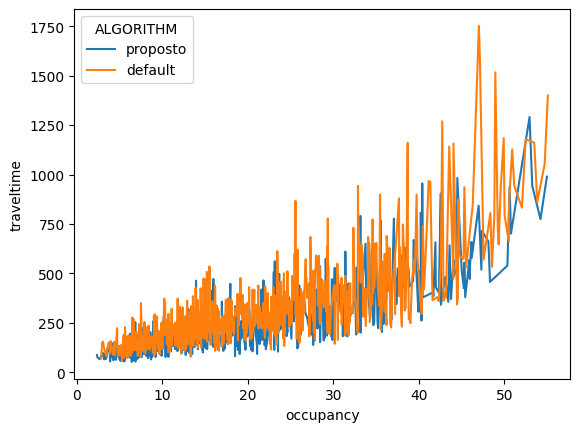

In [29]:
sns.lineplot(data=new_df_agg, x='occupancy', y='traveltime', hue='ALGORITHM')

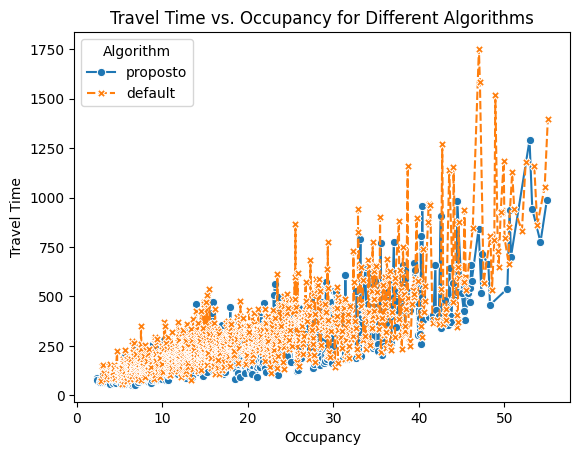

In [32]:
# Assuming you've already aggregated the data
sns.lineplot(data=new_df_agg, x='occupancy', y='traveltime', hue='ALGORITHM', 
             style='ALGORITHM', markers=True,)

plt.xlabel("Occupancy")
plt.ylabel("Travel Time")
plt.title("Travel Time vs. Occupancy for Different Algorithms")
plt.legend(title='Algorithm')
plt.show()

In [34]:
import scipy.signal as signal

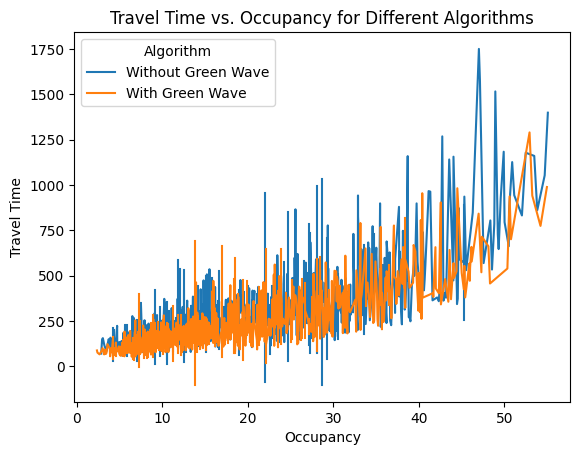

In [71]:
# Filter data for each algorithm
default_df = new_df[new_df['ALGORITHM'] == 'default']
proposto_df = new_df[new_df['ALGORITHM'] == 'proposto']

# Now you can use these Series for plotting
sns.lineplot(x=default_df['occupancy'], y=default_df['traveltime'], label='Without Green Wave',  err_style="bars", errorbar=("se", 2),)
sns.lineplot(x=proposto_df['occupancy'], y=proposto_df['traveltime'], label='With Green Wave',  err_style="bars", errorbar=("se", 2),)

plt.xlabel("Occupancy")
plt.ylabel("Travel Time")
plt.title("Travel Time vs. Occupancy for Different Algorithms")
plt.legend(title='Algorithm')
plt.show()

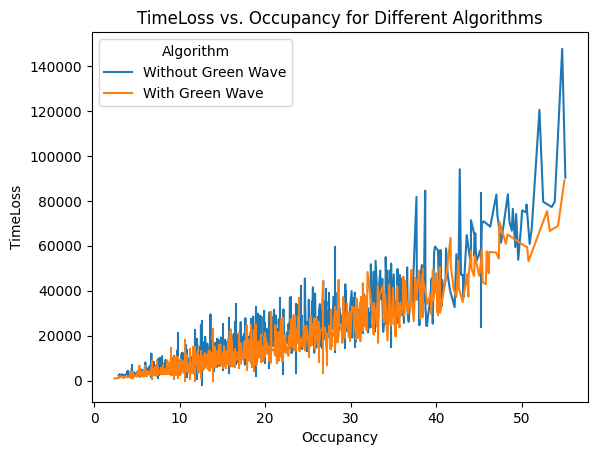

In [70]:
# Filter data for each algorithm
default_df = new_df[new_df['ALGORITHM'] == 'default']
proposto_df = new_df[new_df['ALGORITHM'] == 'proposto']

# Now you can use these Series for plotting
sns.lineplot(x=default_df['occupancy'], y=default_df['timeLoss'], label='Without Green Wave', err_style="bars", errorbar=("se", 2),)
sns.lineplot(x=proposto_df['occupancy'], y=proposto_df['timeLoss'], label='With Green Wave', err_style="bars", errorbar=("se", 2),)

plt.xlabel("Occupancy")
plt.ylabel("TimeLoss")
plt.title("TimeLoss vs. Occupancy for Different Algorithms")
plt.legend(title='Algorithm')
plt.show()

In [65]:
from scipy.interpolate import make_interp_spline

In [69]:
default_df = new_df[new_df['ALGORITHM'] == 'default'].sort_values(by=['occupancy'])
proposto_df = new_df[new_df['ALGORITHM'] == 'proposto'].sort_values(by=['occupancy'])

x = default_df['occupancy']
y = proposto_df['timeLoss']
cubic_interpolation_model = make_interp_spline(x, y)

# Plotting the Graph
X_=np.linspace(x.min(), x.max(), 500)
Y_=cubic_interpolation_model(X_)
 
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.interp1d Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


ValueError: Expect x to not have duplicates